In [114]:
import os
import re
import cv2
import keras
import skimage

import numpy as np
from tqdm import tqdm
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras import backend as K
K.set_image_dim_ordering('th')

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [41]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r"[^a-zA-Z, :]", " ", name).title()

In [42]:
# Configure input/output directory
# Configure training, validation, testing directory

input_directory = r"/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/"
output_directory = r"/kaggle/output/chest-xray-pneumonia/chest_xray/chest_xray/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"

## Preprocessing

In [43]:
def get_data(directory):
    X = []
    y = []
    
    for nextdir in os.listdir(directory):
        if not nextdir.startswith("."):
            if nextdir in ["NORMAL"]:
                label = 0
            elif nextdir in ["PNEUMONIA"]:
                label = 1
            else:
                label = 2
            
            temp = directory + "/" + nextdir
        
            for image_filename in tqdm(os.listdir(temp)):
                path = os.path.join(temp + "/", image_filename)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y

In [44]:
X_train, y_train = get_data(training_dir)
X_test, y_test = get_data(testing_dir)

100%|██████████| 390/390 [00:18<00:00, 20.85it/s]


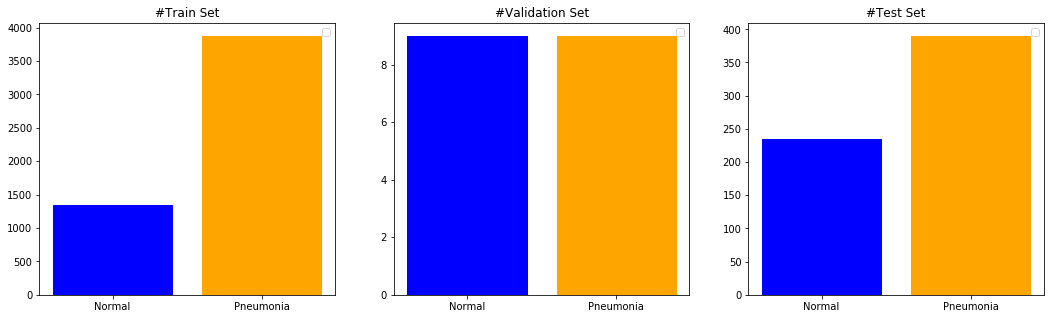

In [45]:
x = ["Normal", "Pneumonia"]
y1 = [len(os.listdir(training_dir + "/NORMAL")), len(os.listdir(training_dir + "/PNEUMONIA"))]
y2 = [len(os.listdir(validation_dir + "/NORMAL")), len(os.listdir(validation_dir + "/PNEUMONIA"))]
y3 = [len(os.listdir(testing_dir + "/NORMAL")), len(os.listdir(testing_dir + "/PNEUMONIA"))]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
ax1.bar(x=np.arange(len(x)), height=y1, width=0.8, color=["blue", "orange"], edgecolor=["blue", "orange"])
ax1.set_title("#Train Set")
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x)
ax1.legend()

ax2.bar(x=np.arange(len(x)), height=y2, width=0.8, color=["blue", "orange"], edgecolor=["blue", "orange"])
ax2.set_title("#Validation Set")
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x)
ax2.legend()

ax3.bar(x=np.arange(len(x)), height=y3, width=0.8, color=["blue", "orange"], edgecolor=["blue", "orange"])
ax3.set_title("#Test Set")
ax3.set_xticks(np.arange(len(x)))
ax3.set_xticklabels(x)
ax3.legend()

plt.show()

In [46]:
print("X_train Shape: " + str(X_train.shape))
print("X_test Shape: " + str(X_test.shape))
print("y_train Shape: " + str(y_train.shape))
print("y_test Shape: " + str(y_test.shape))

X_train Shape: (5216, 150, 150, 3)
X_test Shape: (624, 150, 150, 3)
y_train Shape: (5216,)
y_test Shape: (624,)


In [47]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [48]:
Pneumonia_images = os.listdir(training_dir + "/PNEUMONIA")
Normal_images = os.listdir(training_dir + "/NORMAL")

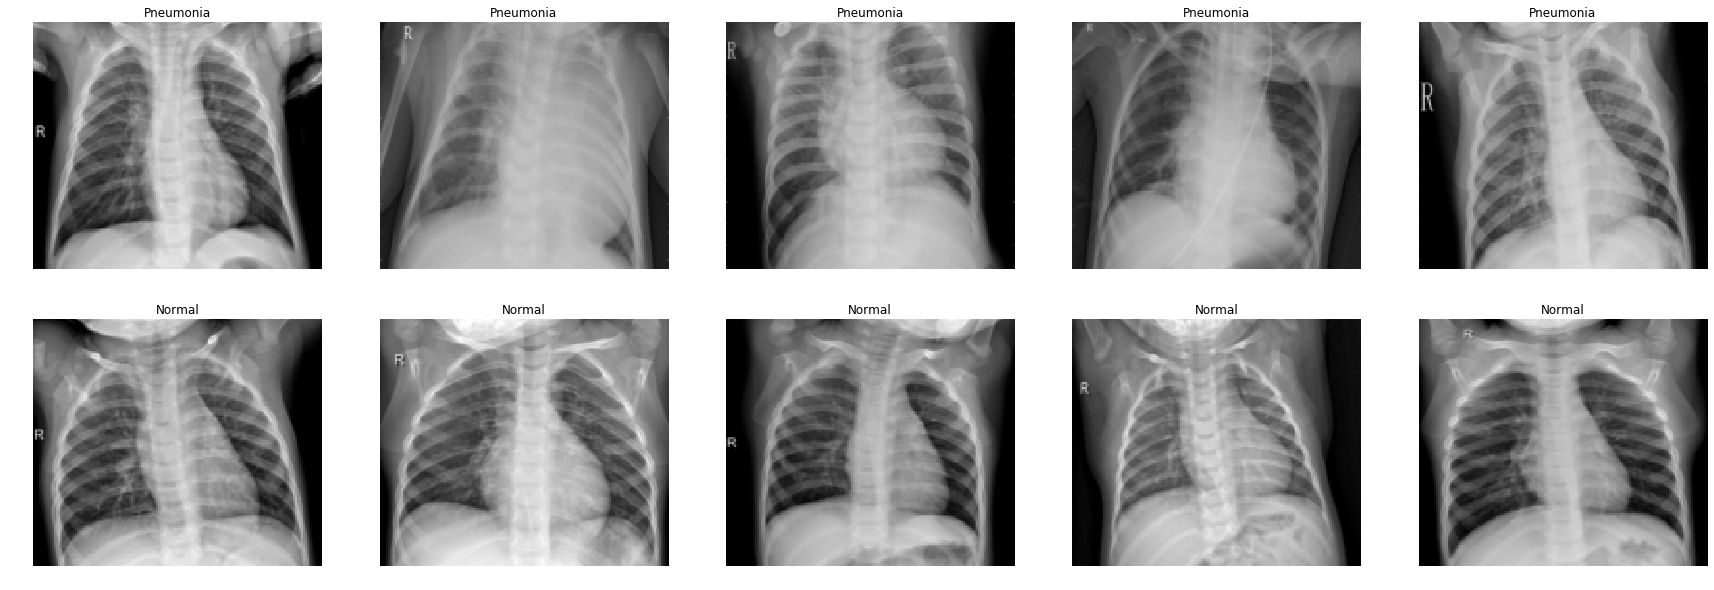

In [49]:
pneumonia_sample = []
normal_sample = []
for i in range(0, 5):
    pneumo = cv2.imread(training_dir + "/PNEUMONIA/" + Pneumonia_images[i])
    normal = cv2.imread(training_dir + "/NORMAL/" + Normal_images[i])
    
    pneumo = skimage.transform.resize(pneumo, (150, 150, 3), mode="reflect")
    normal = skimage.transform.resize(normal, (150, 150, 3))
    
    pneumonia_sample.append(pneumo)
    normal_sample.append(normal)

sample = pneumonia_sample + normal_sample
del pneumonia_sample, normal_sample

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    ax[i // 5, i % 5].imshow(sample[i], cmap="gray")
    if i<5:
        ax[i // 5, i % 5].set_title("Pneumonia")
    else:
        ax[i // 5, i % 5].set_title("Normal")
    ax[i // 5, i % 5].axis("off")
    ax[i // 5, i % 5].set_aspect("auto")
plt.show()

In [119]:
# initialize the base pretrained model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model1 = tf.keras.Sequential([
    base_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dense(2, activation="sigmoid")
])

model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               262272    
_________________________________________________________________
batch_normalization_948 (Bat (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 258       
Total params: 22,065,826
Trainable params: 262,786
Non-trainable params: 21,803,040
____________________________________

In [120]:
batch_size = 32
epochs = 25

filepath = "transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.01, patience=2, min_delta=1E-7, verbose=1)
early_stop = EarlyStopping(monitor="val_acc", mode="max", min_delta=1E-7, patience=5, restore_best_weights=True, verbose=1)

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history1 = model1.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[lr_reduce, early_stop, checkpoint])

Train on 5216 samples, validate on 624 samples
Epoch 1/25
5184/5216 [============================>.] - ETA: 0s - loss: 0.2972 - acc: 0.8731
Epoch 00001: val_acc improved from -inf to 0.64423, saving model to transferlearning_weights.hdf5
5216/5216 [==============================] - 44s 9ms/sample - loss: 0.2966 - acc: 0.8733 - val_loss: 0.7131 - val_acc: 0.6442
Epoch 2/25
5184/5216 [============================>.] - ETA: 0s - loss: 0.2020 - acc: 0.9184
Epoch 00002: val_acc did not improve from 0.64423
5216/5216 [==============================] - 9s 2ms/sample - loss: 0.2029 - acc: 0.9183 - val_loss: 0.6515 - val_acc: 0.5865
Epoch 3/25
5152/5216 [============================>.] - ETA: 0s - loss: 0.1877 - acc: 0.9220
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00003: val_acc did not improve from 0.64423
5216/5216 [==============================] - 16s 3ms/sample - loss: 0.1883 - acc: 0.9212 - val_loss: 1.0378 - val_acc: 0.4888
Epoch 4/25
5152/5

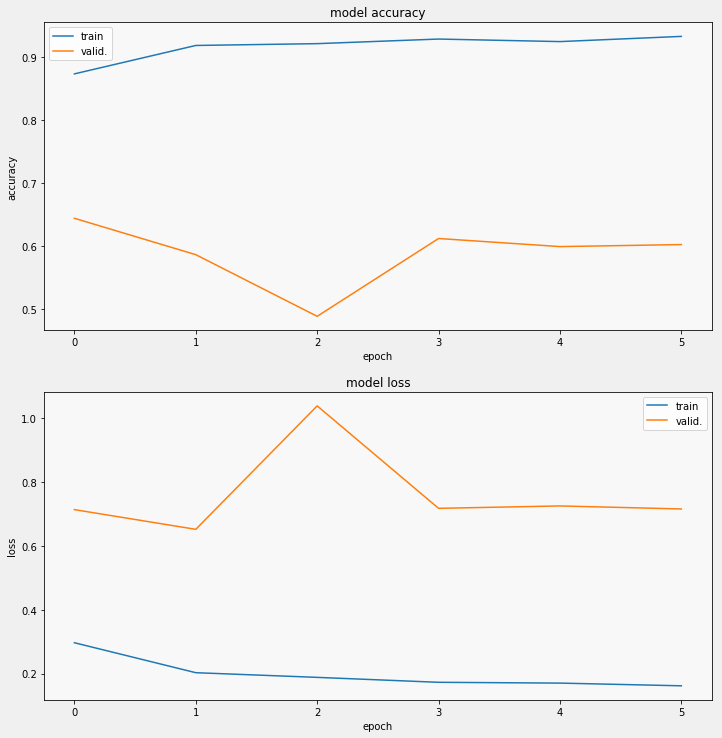

In [121]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(history1.history["acc"], history1.history["val_acc"], "accuracy", 211)
display_training_curves(history1.history["loss"], history1.history["val_loss"], "loss", 212)

In [122]:
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)
    
for layer in model.layers[:249]:
     layer.trainable = False
for layer in model.layers[249:]:
     layer.trainable = True

In [123]:
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.01, patience=2, min_delta=1E-7, verbose=1)
early_stop = EarlyStopping(monitor="val_acc", mode="max", min_delta=1E-7, patience=5, restore_best_weights=True, verbose=1)

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history1 = model1.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[lr_reduce, early_stop, checkpoint])

Train on 5216 samples, validate on 624 samples
Epoch 1/25
5184/5216 [============================>.] - ETA: 0s - loss: 0.2123 - acc: 0.9128
Epoch 00001: val_acc improved from -inf to 0.45353, saving model to transferlearning_weights.hdf5
5216/5216 [==============================] - 34s 6ms/sample - loss: 0.2120 - acc: 0.9130 - val_loss: 1.4154 - val_acc: 0.4535
Epoch 2/25
5184/5216 [============================>.] - ETA: 0s - loss: 0.1924 - acc: 0.9223
Epoch 00002: val_acc improved from 0.45353 to 0.60897, saving model to transferlearning_weights.hdf5
5216/5216 [==============================] - 9s 2ms/sample - loss: 0.1922 - acc: 0.9222 - val_loss: 0.9343 - val_acc: 0.6090
Epoch 3/25
5152/5216 [============================>.] - ETA: 0s - loss: 0.1921 - acc: 0.9194
Epoch 00003: val_acc improved from 0.60897 to 0.64103, saving model to transferlearning_weights.hdf5
5216/5216 [==============================] - 9s 2ms/sample - loss: 0.1918 - acc: 0.9195 - val_loss: 0.8478 - val_acc: 0.641

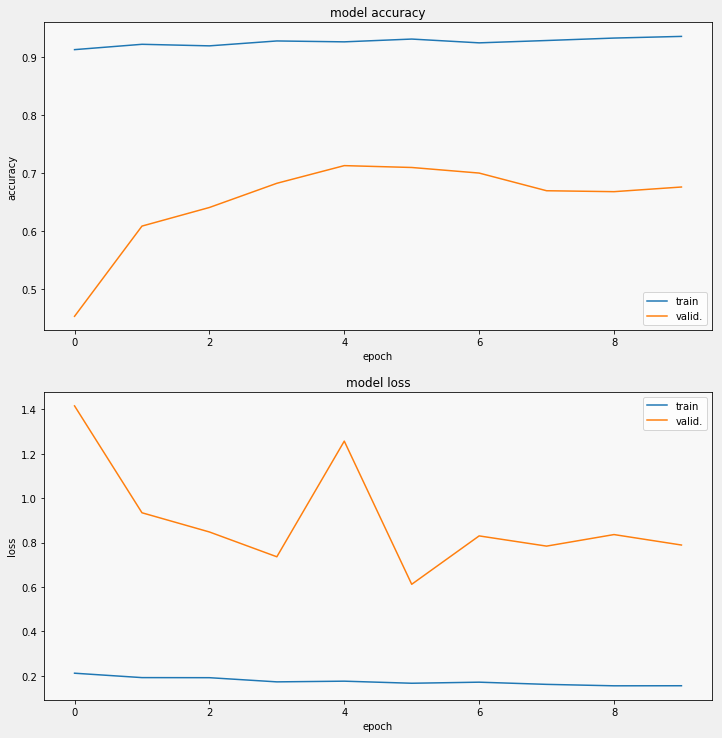

In [124]:
display_training_curves(history1.history["acc"], history1.history["val_acc"], "accuracy", 211)
display_training_curves(history1.history["loss"], history1.history["val_loss"], "loss", 212)

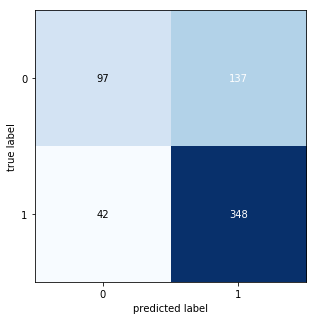

In [125]:
y_pred1 = model1.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis=1) 
y_true = np.argmax(y_test, axis=1)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_true, y_pred1), figsize=(5, 5))
plt.show()

### Testing if InceptionV3 works better without pretrained wheights

In [126]:
# initialize the base pretrained model
base_model = InceptionV3(weights=None, include_top=False, input_shape=(150, 150, 3))
base_model.trainable = True

model2 = tf.keras.Sequential([
    base_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dense(2, activation="sigmoid")
])

model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               262272    
_________________________________________________________________
batch_normalization_1043 (Ba (None, 128)               512       
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 258       
Total params: 22,065,826
Trainable params: 22,031,138
Non-trainable params: 34,688
_____________________________________

In [127]:
batch_size = 32
epochs = 25

filepath = "without_pretrained_inceptionv3_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.01, patience=2, min_delta=1E-7, verbose=1)
early_stop = EarlyStopping(monitor="val_acc", mode="max", min_delta=1E-7, patience=5, restore_best_weights=True, verbose=1)

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[lr_reduce, early_stop, checkpoint])

Train on 5216 samples, validate on 624 samples
Epoch 1/25
5184/5216 [============================>.] - ETA: 0s - loss: 0.2126 - acc: 0.9147
Epoch 00001: val_acc improved from -inf to 0.62500, saving model to without_pretrained_inceptionv3_weights.hdf5
5216/5216 [==============================] - 69s 13ms/sample - loss: 0.2137 - acc: 0.9145 - val_loss: 3.2802 - val_acc: 0.6250
Epoch 2/25
5184/5216 [============================>.] - ETA: 0s - loss: 0.1322 - acc: 0.9543
Epoch 00002: val_acc did not improve from 0.62500
5216/5216 [==============================] - 20s 4ms/sample - loss: 0.1317 - acc: 0.9544 - val_loss: 3.2654 - val_acc: 0.6250
Epoch 3/25
5184/5216 [============================>.] - ETA: 0s - loss: 0.0931 - acc: 0.9655
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00003: val_acc did not improve from 0.62500
5216/5216 [==============================] - 29s 6ms/sample - loss: 0.0931 - acc: 0.9655 - val_loss: 2.3949 - val_acc: 0.6250
E

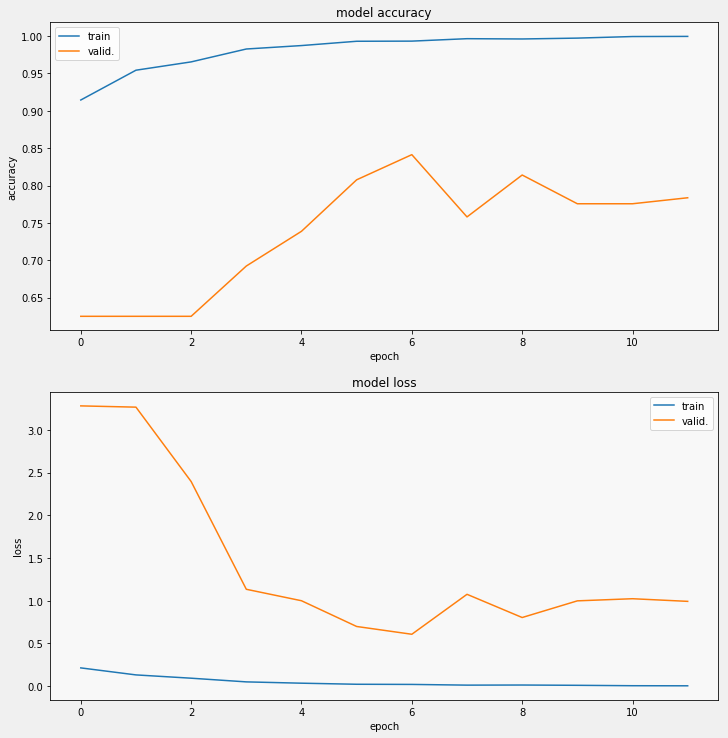

In [128]:
display_training_curves(history2.history["acc"], history2.history["val_acc"], "accuracy", 211)
display_training_curves(history2.history["loss"], history2.history["val_loss"], "loss", 212)

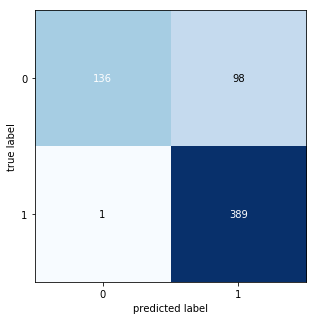

In [129]:
y_pred2 = model2.predict(X_test)
y_pred2 = np.argmax(y_pred2, axis=1) 
y_true = np.argmax(y_test, axis=1)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_true, y_pred2), figsize=(5, 5))
plt.show()

In [131]:
y_test_decoded = []
for i in y_test:
    if i[0] == 1:
        y_test_decoded.append(0)
    else:
        y_test_decoded.append(1)

Accuracy Model 1: 0.7131410256410257
F1 Score Model 1: 0.7954285714285714
Precision Score Model 1: 0.7175257731958763
Recall Score Model 1: 0.8923076923076924

Accuracy Model 2: 0.8413461538461539
F1 Score Model 2: 0.887115165336374
Precision Score Model 2: 0.7987679671457906
Recall Score Model 2: 0.9974358974358974

Left: Pretrained InceptionV3 vs Right: Untrained InceptionV3


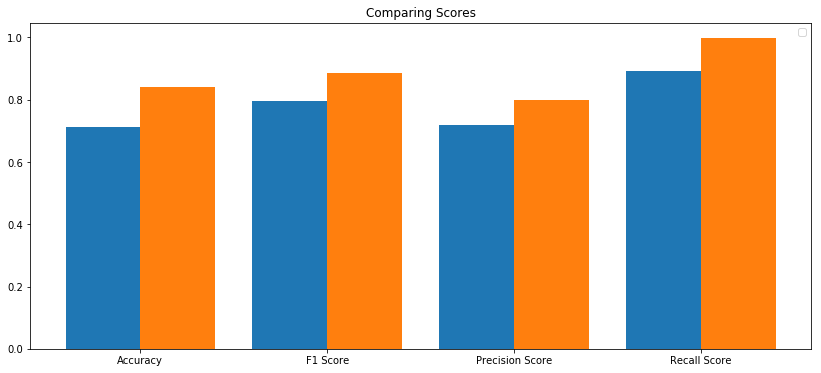

In [140]:
accuracy_model1 = accuracy_score(y_test_decoded, y_pred1)
f1_model1 = f1_score(y_test_decoded, y_pred1)
precision_model1 = precision_score(y_test_decoded, y_pred1)
recall_model1 = recall_score(y_test_decoded, y_pred1)

print("Accuracy Model 1: " + str(accuracy_model1))
print("F1 Score Model 1: " + str(f1_model1))
print("Precision Score Model 1: " + str(precision_model1))
print("Recall Score Model 1: " + str(recall_model1))
print()
accuracy_model2 = accuracy_score(y_test_decoded, y_pred2)
f1_model2 = f1_score(y_test_decoded, y_pred2)
precision_model2 = precision_score(y_test_decoded, y_pred2)
recall_model2 = recall_score(y_test_decoded, y_pred2)

print("Accuracy Model 2: " + str(accuracy_model2))
print("F1 Score Model 2: " + str(f1_model2))
print("Precision Score Model 2: " + str(precision_model2))
print("Recall Score Model 2: " + str(recall_model2))
print()
print("Left: Pretrained InceptionV3 vs Right: Untrained InceptionV3")

width = 0.4
labels = ["Accuracy", "F1 Score", "Precision Score", "Recall Score"]
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - width/2, height=[accuracy_model1, f1_model1, precision_model1, recall_model1], width=width)
ax.bar(x + width/2, height=[accuracy_model2, f1_model2,precision_model2, recall_model2], width=width)#, color=["red", "blue", "orange", "green"])

ax.set_title("Comparing Scores")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [ ]:
""